# Final Project - Analysis of the Causal Effect of Reach on the Number of Significant Strikes Landed per Min in the UFC Fights in Account to Heights
Group Members: Byeong Heon Ahn (bha233), Kanishk Aggarwal (ka3506), Dhruv Topiwala (dmt9779)

## Hypothesis

For this project, we will analyze the causal effect of the reach of the fighters on the number of significant strikes landed per minute. To analyze both the total and direct causal effect of the reach on the number of significant strikes landed per minute, we will use the reach and the number of significant strikes landed per minute of the individual fighters on the blue side. The height of the fighters on the blue side will also be considered as one of the potential confounds since it reasonably influences both the reach and the number of significant strikes landed per minute. As a hypothesis, we assume that the reach will be proportionally influence the number of significant strikes landed per minute when the height is accounted (longer the reach greater number of significant strikes the fighter would land per minute).

## Dataset

We will use the $\href{https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset/data}{Ultimate-UFC-Fights-dataset}$ (ufc_master.csv), which includes the various data of each fights. Since we are exploring the hypothesis of the influence of the reach on the number of significant strikes landed per minute while the height is also considered as a confound, the reach, height, and the number of significant strikes landed per minute of the fighters on the blue side will be used in this project.

To use the dataset, we downloaded the csv file and included in the project folder in the Data directory so it is easier to access and handle the dataset. The dataset is accessed through:

pd.read_csv("Data/ufc_master.csv")

For this project, we will only be using the "BlueHeightCms", "BlueReachCms", and "BlueAvgSigStrLanded" as explained above.

## Causal Model

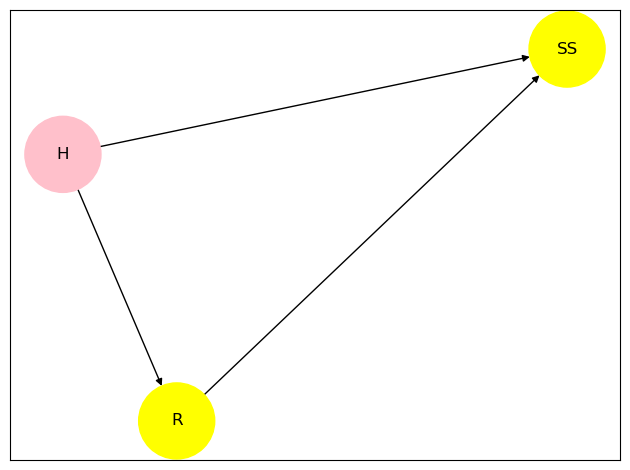

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("H", "R"), ("H","SS"), ("R","SS")])
nx.draw_networkx(graph, arrows=True, node_color= ["pink", "yellow", "yellow"], node_size=3000)
plt.tight_layout()

The DAG graph above represents the causal relationships between the reach (R), height (H), and the number of significant strikes landed per minute (SS). As briefly addressed in the hypothesis, the associations between the variables are made under a reasonable scientific model:

1. R_i = $f_{R} (H_i)$

The height of a fighter (H) directly influences the reach of the fighter (R) since the reach gets longer as human grows and gets taller.

2. SS_i = $f_{SS} (R_i, H_i)$

Both the the reach (R) and the height (H) directly affect the number of significant strikes landed per minute since having the longer reach and being taller than the opponent means that the fighter has a bigger safety zone and easier to reach to the opponent so that one can land more significant strikes easily and safely.

Thus, as we see that the height (H) is a confounder (H affects both R and SS  [R $\leftarrow$ H $\rightarrow$ SS]), we need to condition on the height when measuring both the direct and total causal effects of the reach on the number of significant strikes landed per minute; the height will be included in the statistical model to measure both the direct and total causal effects of R on SS.

## Statistical Model

### Prior Predictive Simulation

Before the prior predictive simulation, the ufc_master.csv data will be explored.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import networkx as nx
from scipy.special import expit as logistic

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
df = pd.read_csv("Data/ufc-master.csv")
columns = ["BlueReachCms", "BlueHeightCms", "BlueAvgSigStrLanded"]
print(columns)
df = df[columns]
df.head()

['BlueReachCms', 'BlueHeightCms', 'BlueAvgSigStrLanded']


,BlueReachCms,BlueHeightCms,BlueAvgSigStrLanded
0,175.26,172.72,0.00
1,187.96,190.50,5.50
2,203.20,200.66,5.13
3,177.80,175.26,3.74
4,177.80,177.80,4.41


### Research on Average Reach, Height, and Number of Significant Strikes Landed per Minute of UFC Fighters

From the research, the $\href{https://www.reference.com/science-technology/average-human-arm-span-c07bdf92e5fa8755}{Reference}$ website states that the average arm span length for man is about 5 feet 9 inches (175.26 cm). Since it was hard to find the average reach length of the UFC fighters across all weight classes, we will use this general average arm span length information for man as the average reach length of the UFC fighters. Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 175.26 cm as the average reach length of the UFC fighters.

According to the $\href{https://jokermag.com/average-height-ufc-fighters/}{jokermag}$ website, it states the average height of the UFC fighters across all weight classes is about 5 feet 9.5 inches (176.62 cm). Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 176.62 cm as the average height of the UFC fighters.

From the research, we could not find the average number of significant strikes landed per minute of the UFC fighters. However, according to the $\href{http://statleaders.ufc.com/career?fighter_status=0}{Official-UFC-Record-Book}$, the highest significant strikes landed per minute is 8.10. Since the possible least significant strikes landed per minute will be 0, we are going to estimate the average number of significant strikes landed per minute is 4.05 with a standard deviation of 1.

With this researched information, we will identify any inappropriate data points (outliers) in the dataset to clean and process the dataset. We will double-check if the pre-processed dataset has the appropriate data values for the number of significant strikes landed per minute.

In [5]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min:")
print(df[num_sig_str].min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min:")
print(df[num_sig_str].max())

The minimum number of significant strikes landed per min:
BlueAvgSigStrLanded    0.0
dtype: float64

The maximum number of significant strikes landed per min:
BlueAvgSigStrLanded    154.0
dtype: float64


From the min and max values above, we see that while the minimum values is reasonable (it is possible to have a 0 significant strike landed per minute sometimes since there are some fights which ends in few seconds with just one significant attack, in which case the significant attack of the person lost would be 0), it is not reasonable that a fighter would land 154 significant strikes per minute in a fight. Also, as the official UFC Record Book states that the highest significant strikes landed per min is 8.10, we can conclude that some of the data points in the dataset are not reasonable. Thus, we will further process the data points that has the number of significant strikes landed per minute over 8.10. Moreover, before we proceed to the prior predictive simulation, we will clean up and process the dataset by dropping the NaN values and making sure that the reach and height also has the reasonable values.

In [6]:
# Cleaning dataset for any data point that has NaN value
processed_df = df.dropna()

# Cleaning dataset for any data point that has the BlueAvgSigStrLanded values greater than 8.10
processed_df = processed_df[processed_df['BlueAvgSigStrLanded'] <= 8.10]

# Cleaning dataset for any data point that has the BlueReachCms or BlueHeightCms < 100
processed_df = processed_df[(processed_df['BlueReachCms'] > 100) & (processed_df['BlueHeightCms'] >100)]

# Check if the processed dataset is clean
print("Any NaN in the processed dataset:\n", processed_df.isna().any().any())

print("\nAny number of significant strike landed per min greater than 8.10:\n", np.where(processed_df[["BlueAvgSigStrLanded"]]>8.10))

print("\nAny reach or height of the figher less than 100:\n", np.where(processed_df[["BlueReachCms", "BlueHeightCms"]]<100))

Any NaN in the processed dataset:
 False

Any number of significant strike landed per min greater than 8.10:
 (array([], dtype=int64), array([], dtype=int64))

Any reach or height of the figher less than 100:
 (array([], dtype=int64), array([], dtype=int64))


In [7]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].min())
print("The standardized minimum number of significant strikes landed per min in processed dataset:")
print(standardize(processed_df[num_sig_str]).min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].max())
print("The standardized maximum number of significant strikes landed per min in processed dataset:")
print(standardize(processed_df[num_sig_str]).max())

The minimum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    0.0
dtype: float64
The standardized minimum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded   -2.4761
dtype: float64

The maximum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    8.07
dtype: float64
The standardized maximum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    2.631653
dtype: float64


### Plot the Real Data Points and Find Min and Max Values of Standardized Reach and Height for Ranges

We will now plot the real data points where the values for reach, height, and the number of significant strikes landed per minute. Moreover, we will be standardizing the values of number of significant strike landed per minute, reach, and height for better interpretation since the magnitude and range of these values are too big when the reach/height is compared to the number of significant strike landed per minute.

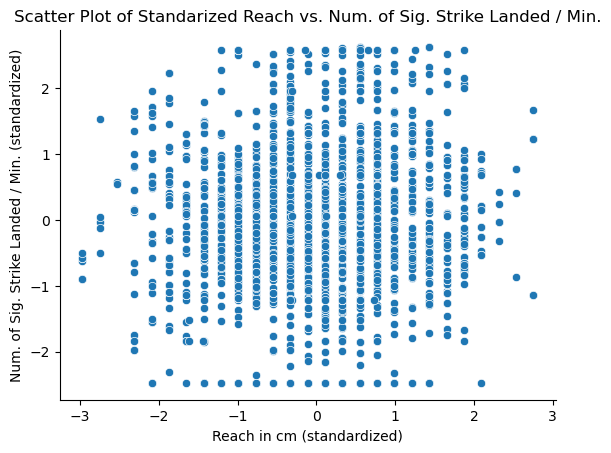

In [8]:
sns.scatterplot(x = standardize(processed_df.BlueReachCms), y = standardize(processed_df.BlueAvgSigStrLanded))
plt.xlabel("Reach in cm (standardized)")
plt.ylabel("Num. of Sig. Strike Landed / Min. (standardized)")
plt.title("Scatter Plot of Standarized Reach vs. Num. of Sig. Strike Landed / Min.")
sns.despine();

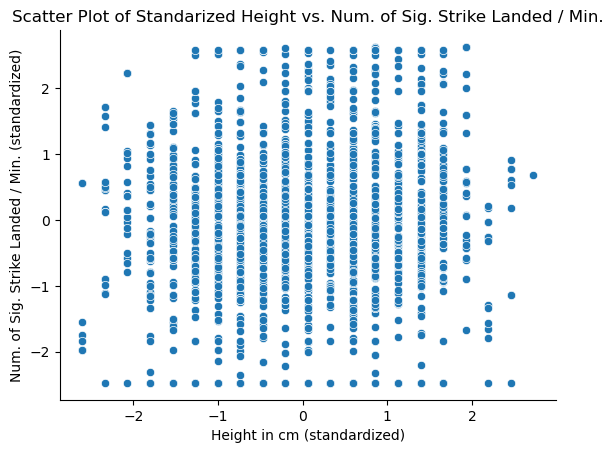

In [9]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = standardize(processed_df.BlueAvgSigStrLanded))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Num. of Sig. Strike Landed / Min. (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Num. of Sig. Strike Landed / Min.")
sns.despine();

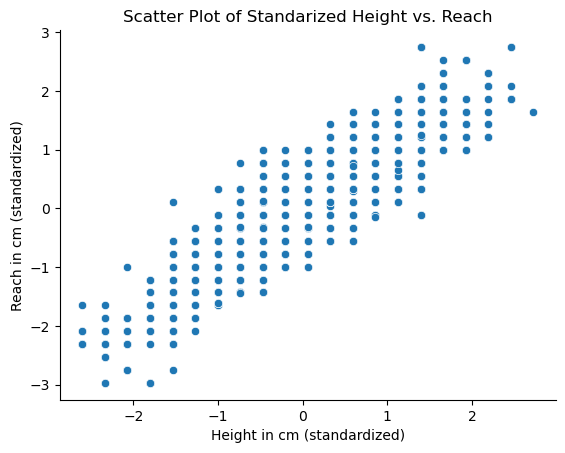

In [10]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = standardize(processed_df.BlueReachCms))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Reach in cm (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Reach")
sns.despine();

In [11]:
print("The minimum value of standardized reach:",standardize(processed_df["BlueReachCms"]).min())
print("The maximum value of standardized reach:",standardize(processed_df["BlueReachCms"]).max())

print("\nThe minimum value of standardized height:",standardize(processed_df["BlueHeightCms"]).min())
print("The maximum value of standardized height:",standardize(processed_df["BlueHeightCms"]).max())

The minimum value of standardized reach: -2.9723097680915673
The maximum value of standardized reach: 2.7518343339335476

The minimum value of standardized height: -2.604593436420147
The maximum value of standardized height: 2.7237521618323144


### Prior Predictive Simulations

With the min and max values of standardized reach and height, we will set the range of the x-axis from -3 to 2.8 for the prior simulation of reach and from -2.7 to 2.8 for the prior simulation of height. The range of the y-axis will be set from -2.5 to 2.7 since the min and max values of the standardized number of significant strike landed per minute are -2.48 and 2.63 respectively.

Based on the causal relationship we examined with the DAG graph, we will formulate the statistical model with the predictive priors for reach and height.

For the statistical model for both the total and direct causal effect of the reach on the number of significant strike landed per minute, 

- We previously formulated the causal model as $SS_i = f_{ss}(R_i, H_i)$ where the height is included in the model as the predictor variable since it is conditioned on for being a confounder, as well as the reach which is in the model as the treatment variable. Elaborating the causal model more in detail, we will use the standard distribution for the number of significant strike landed per minute, which is the normal distribution, where $\mu_i$ is the expectation value of the number of significant strikes landed per minute and $\sigma$ is the standard deviation of the number of significant strikes landed per minute.

- The $\sigma$ will be set with the exponential distribution with lambda of 1 as one of the standard distributions assigned for $\sigma$.

- The $\mu_i$ will be set with the linear equation ($\mu_i = \alpha + \beta_R R_i + \beta_H H_i$) which is deterministic, where $\alpha$ is the value of $\mu$ when $R_i$ and $H_i$ are 0 and $\beta_R$ and $\beta_H$ are the distributions, which will be tested and assigned with the prior distribution of reach and height that we will explore and find the reasonable ones for them in this section. 

- The $\alpha$, which is the y-intercept of the standardized number of significant strikes landed per minute will be set with the normal distribution with its $\mu$ and $\sigma$ being set with the average and standard deviation of the standardized number of significant strike landed per minute, which are 0.08 (the mean of -2.48 and 2.63) and 1 respectively.

Thus, for the first prior predictive simulation, we will try the normal distribution with $\mu$ = 0 and $\sigma$ = 10 for $\beta_R$ and $\beta_H$:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_H H_i$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 10)$

$\beta_H \sim Normal(0, 10)$

$\sigma \sim Exponential(1)$

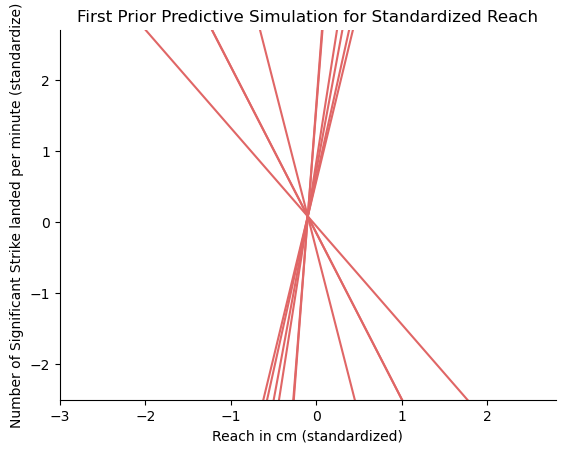

In [12]:
# First prior predictive simulation for reach
NUM_LINES = 10

x_seq = np.linspace(-3, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1, size=NUM_LINES, random_state = 42)
beta_R = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_R[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardize)")
_ = plt.xlabel("Reach in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Reach")
_ = plt.xlim(-3, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

From the plot above on the first prior predictive simulation of reach with $\beta_R \sim Normal(0, 10)$, it is reasonable for the prior lines to have either positive or negative slope since increasing reach could result in either increase or decrease of the number of significant strike landed per minute; while we can generalize it for reach and height such that increasing reach and height would always increase the number of significant strikes landed per minute, we will consider the realistic possibility of increasing reach and height resulting in decrease of number of significant strike landed per minute.

However, according to the plot, the small increases of the reach length lead to the dramatic expected number of significant strike landed per minute. Thus, the prior lines are not representing the realistic relations between the reach and the number of significant strike landed per minute. Moreover, throughout the range of the standardized reach, the expected standardized number of significant strike landed per minute goes beyond the desired range, which is from -2.48 and 2.63.

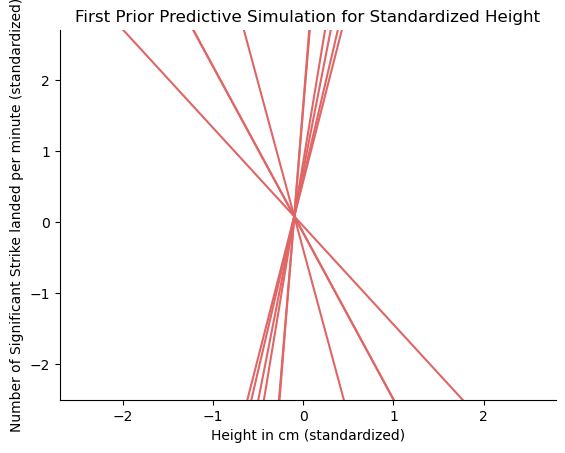

In [13]:
# First prior predictive simulation for height
NUM_LINES = 10

x_seq = np.linspace(-2.7, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_H = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_H[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Height in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Height")
_ = plt.xlim(-2.7, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

The plot above is the first prior predictive simulation of height with $\beta_H \sim Normal(0, 10)$. Similar to the prior lines simulated for reach, it is reasonable for the prior lines to have either positive or negative slope since increasing height could result in either increase or decrease of the number of significant strike landed per minute.

However, the small increases of the height lead to the dramatic expected number of significant strike landed per minute. Thus, the prior lines do not represent the realistic relations between the height and the number of significant strike landed per minute. Furthermore, this plot also shows that within the range of the standardized height, the expected standardized number of significant strike landed per minute goes beyond the desired range from -2.48 and 2.63.

Thus, we concluded that setting the prior distribution as $\beta_R \sim Normal(0, 10)$ and $\beta_H \sim Normal(0, 10)$ for reach and height, respectively, does not represent the realistic relations of each variable with the number of significant strike landed per minute. However, we analyzed that it is appropriate to use the normal distribution for both betas as the normal distribution generates either positive or negative relations between each variable with the number of significant strike landed per minute, which we desired as described before.

As a result, we will continue to use the normal distribution for both betas. For the second prior predictive simulation of each variable, we will change the standard deviation of the normal distribution from 10 to 0.3, which will decrease variance of the magnitude of the betas when they are randomly sampled.

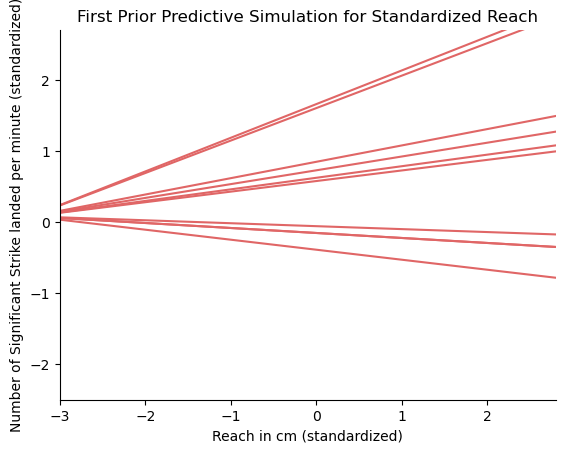

In [14]:
# Second prior predictive simulation for reach
NUM_LINES = 10

x_seq = np.linspace(-3, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_R = stats.norm.rvs(0, 0.3, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_R[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Reach in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Reach")
_ = plt.xlim(-3, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

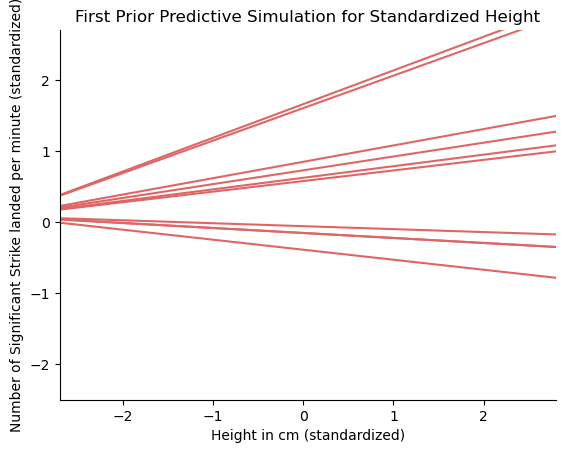

In [15]:
# Second prior predictive simulation for height
NUM_LINES = 10

x_seq = np.linspace(-2.7, 2.8, 50)

alpha = stats.norm.rvs(0.08, 1.0, size=NUM_LINES, random_state = 42)
beta_H = stats.norm.rvs(0, 0.3, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    mu = alpha[i] + beta_H[i] * x_seq
    _ = plt.plot(x_seq, mu, color="#e06666")
    
_ = plt.ylabel("Number of Significant Strike landed per minute (standardized)")
_ = plt.xlabel("Height in cm (standardized)")
_ = plt.title("First Prior Predictive Simulation for Standardized Height")
_ = plt.xlim(-2.7, 2.8)
_ = plt.ylim(-2.5, 2.7)
sns.despine();

As illustrated in the plots above for the second prior predictive simulations for reach and height, we observed that each prior plot has either positive or negative slope, which are reasonable. Also, the little increases in reach or height lead to the moderate expected standardized number of significant strike landed per minute, which the expected standardized number of significant strike landed per minute does not exceed dramatically from the range of the standardized number of significant strike landed per minute, which are from -2.48 and 2.63, within the range of the standardized reach/height. Thus, we concluded that for both reach and height, the normal distribution with $\mu$ = 0 and $\sigma$ = 0.3 is the appropriate prior distribution.

### Fit the Model

With the statistical model that we defined and the prior distribution that we found reasonable from the prior predictive simulation, we will fit the model with the dataset we processed before. Also, as explained before, height is included in the model as a predictor variable since it is a confounder that affects both the reach and the number of significant strike landed per minute. The reach is also included in the model as a treatment variable, which we are interested to examine its total and direct causal effects on the target variable. Lastly, the number of significant strike landed per minute is included in the model as the target variable. Furthermore, as mentioned before, the standardized values of number of significant strike landed per minute, reach, and height will be used for better interpretation since their large range of values and magnitude. For the reminder, the statistical model for the total causal effect and the direct causal effect of the reach on the number of significant strike landed per minute are the same since the height will be included in the model for measure the both causal effects as the predictor variable with the reach and the number of significant strike landed per minute.

We will also analyze the quadratic and cubic versions of the models as well as the linear version of the model, which the deterministic equation $\mu_i$ will be changed to $\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_H H_i + \beta_H H_i^2$ and $\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_R R_i^3 + \beta_H H_i + \beta_H H_i^2 + \beta_H H_i^3$, respectively.

Statistical models we defined with the selected prior distributions are:

Linear model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_H H_i$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

Quadratic model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_H H_i + \beta_H H_i^2$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

Cubic model:

$SS_i \sim Normal(\mu_i,\sigma)$

$\mu_i = \alpha + \beta_R R_i + \beta_R R_i^2 + \beta_R R_i^3 + \beta_H H_i + \beta_H H_i^2 + \beta_H H_i^3$

$\alpha \sim Normal(0.08, 1.0)$

$\beta_R \sim Normal(0, 0.3)$

$\beta_H \sim Normal(0, 0.3)$

$\sigma \sim Exponential(1)$

In [16]:
reach_std = standardize(processed_df.BlueReachCms)
height_std = standardize(processed_df.BlueHeightCms)
SigStr_std = standardize(processed_df.BlueAvgSigStrLanded)

In [17]:
# Fit the linear model with processed data
with pm.Model() as linM:
    alpha = pm.Normal('alpha', mu = 0.08, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', alpha + beta_R * reach_std + beta_H * height_std)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_lin = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

az.summary(idata_lin, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_H, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,0.000,0.019,-0.035,0.033
beta_R,-0.049,0.044,-0.132,0.030
beta_H,0.120,0.044,0.039,0.201
sigma,0.998,0.013,0.975,1.022


In [18]:
# Fit the quadratic model with processed data
with pm.Model() as quadM:
    alpha = pm.Normal('alpha', mu = 4.05, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_R2 = pm.Normal('beta_R2', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    beta_H2 = pm.Normal('beta_H2', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', alpha + beta_R * reach_std
                          + beta_R2 * reach_std ** 2 
                          + beta_H * height_std
                          + beta_H2 * height_std ** 2)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_quad = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})
    
az.summary(idata_quad, var_names = ['alpha', 'beta_R', 'beta_R2', 'beta_H', 'beta_H2', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_R2, beta_H, beta_H2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,-0.015,0.025,-0.060,0.031
beta_R,-0.045,0.044,-0.126,0.037
beta_R2,0.002,0.022,-0.041,0.043
beta_H,0.117,0.044,0.031,0.196
beta_H2,0.014,0.025,-0.035,0.060
sigma,0.997,0.013,0.974,1.021


In [19]:
# Fit the cubic model with processed data
with pm.Model() as cubM:
    alpha = pm.Normal('alpha', mu = 4.05, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_R2 = pm.Normal('beta_R2', mu = 0, sigma = 0.3)
    beta_R3 = pm.Normal('beta_R3', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    beta_H2 = pm.Normal('beta_H2', mu = 0, sigma = 0.3)
    beta_H3 = pm.Normal('beta_H3', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)

    mu = pm.Deterministic('mu', alpha + beta_R * reach_std
                          + beta_R2 * reach_std ** 2 
                          + beta_R3 * reach_std ** 3 
                          + beta_H * height_std
                          + beta_H2 * height_std ** 2
                          + beta_H3 * height_std ** 3)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr_std)

    idata_cub = pm.sample(return_inferencedata=True, random_seed=42, idata_kwargs={"log_likelihood": True})

az.summary(idata_cub, var_names = ['alpha', 'beta_R', 'beta_R2', 'beta_R3', 'beta_H', 'beta_H2', 'beta_H3', 'sigma'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_R2, beta_R3, beta_H, beta_H2, beta_H3, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 42 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%
alpha,-0.013,0.025,-0.061,0.033
beta_R,-0.073,0.057,-0.173,0.040
beta_R2,0.001,0.022,-0.040,0.042
beta_R3,0.010,0.012,-0.010,0.033
beta_H,0.172,0.057,0.070,0.280
beta_H2,0.014,0.024,-0.033,0.055
beta_H3,-0.022,0.014,-0.049,0.004
sigma,0.998,0.013,0.973,1.023


### PSIS and WAIC Comparisons among Different Models

Out of the three different models we fitted, we will compare their performance by utilizing the PSIS and WAIC comparison to evaluate the best performing model for predicting the standardized number of significant strike landed per minute.

In [20]:
models = {
    'linear': idata_lin,
    'quadratic': idata_quad,
    'cubic': idata_cub
}

In [21]:
compare_psis = az.compare(
    compare_dict=models,
    ic="loo",
    scale="deviance"
)
compare_psis

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
linear,0,7819.407561,4.052768,0.000000,0.998012,80.762858,0.000000,False,deviance
quadratic,1,7822.560051,6.265487,3.152490,0.000000,81.005536,2.132886,False,deviance
cubic,2,7823.846897,8.291492,4.439336,0.001988,80.922587,4.343095,False,deviance


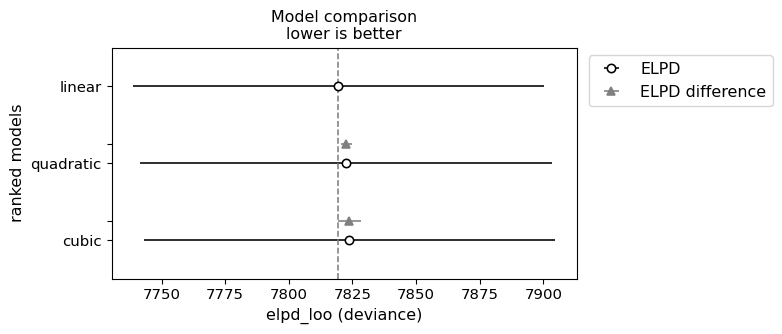

In [22]:
_ = az.plot_compare(compare_psis)

In [23]:
compare_waic = az.compare(
    compare_dict=models,
    ic="waic",
    scale="deviance"
)
compare_waic

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
linear,0,7819.386664,4.042320,0.000000,9.956881e-01,80.762205,0.000000,False,deviance
quadratic,1,7822.529509,6.250216,3.142845,2.914815e-15,81.004646,2.132801,False,deviance
cubic,2,7823.806338,8.271213,4.419675,4.311899e-03,80.921526,4.342608,False,deviance


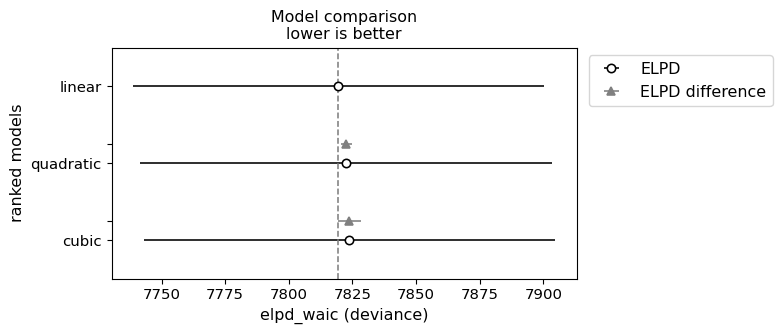

In [24]:
_ = az.plot_compare(compare_waic)

By fitting the linear, quadratic, and cubic version of the regression models to the standardized data and employing PSIS and WAIC to compare the models, we concluded that the linear version of the model performed the best on predicting the standardized number of significant strike landed per minute. It is illustrated in the PSIS and WAIC comparison plots and tables that the linear model has a rank 0 (highest rank among other models) in both PSIS and WAIC comparison with the lowest elpd_loo and elpd_waic scores: 7819.41 and 7819.39, respectively.

Thus, we will analyze the summary of the linear version of the model, which we concluded to have a best performance of predicting the standardized number of significant strike landed per minute, as well as the sampling quality of the model.

In [25]:
az.summary(idata_lin, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,0.000,0.019,-0.035,0.033
beta_R,-0.049,0.044,-0.132,0.030
beta_H,0.120,0.044,0.039,0.201
sigma,0.998,0.013,0.975,1.022


In [26]:
az.summary(idata_lin, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], kind='diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.000,1854.0,1153.0,1.0
beta_R,0.001,0.001,1221.0,1092.0,1.0
beta_H,0.001,0.001,1243.0,1215.0,1.0
sigma,0.000,0.000,1609.0,1459.0,1.0


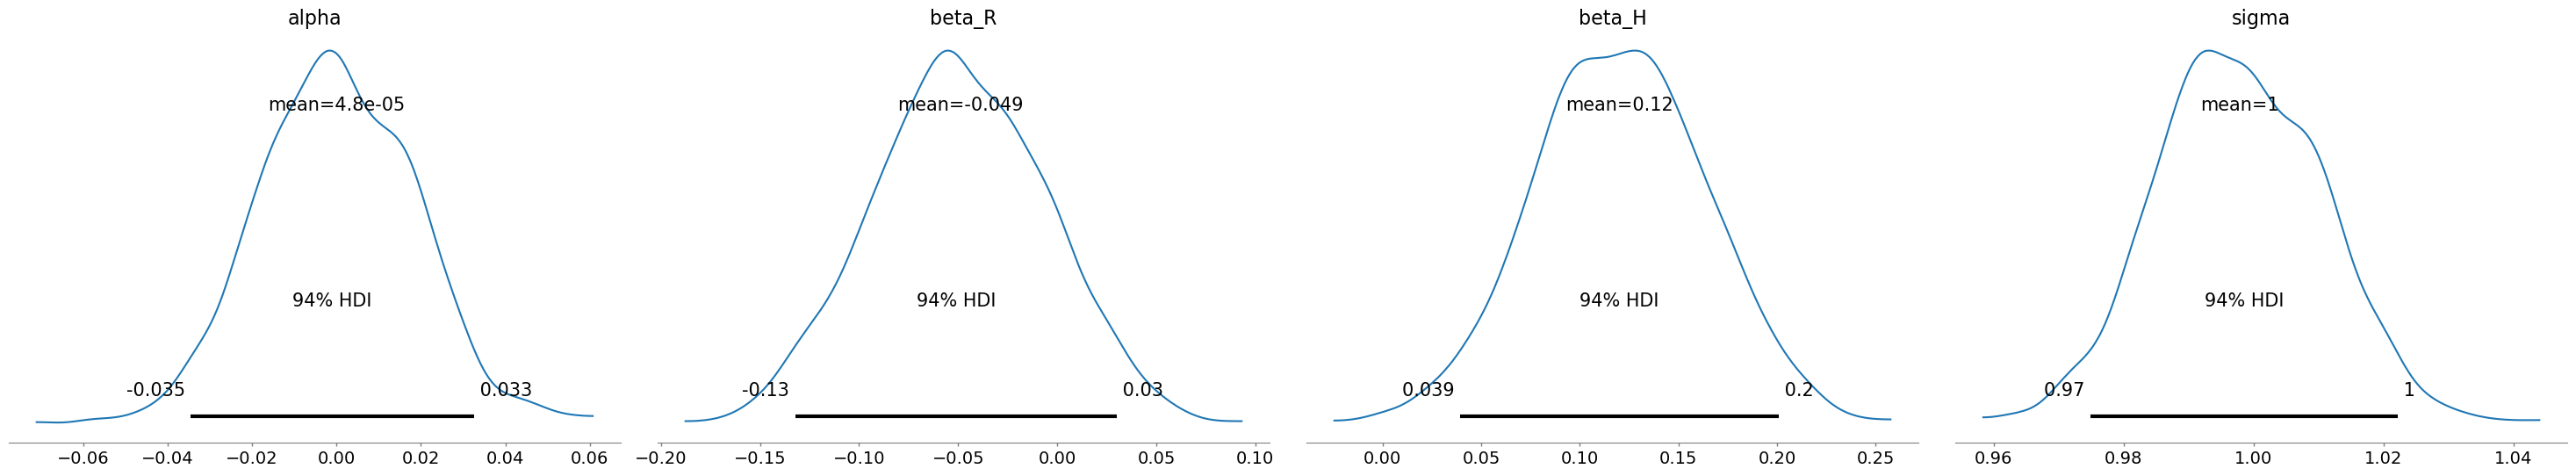

In [27]:
az.plot_posterior(idata_lin, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'])
plt.tight_layout()
plt.show()

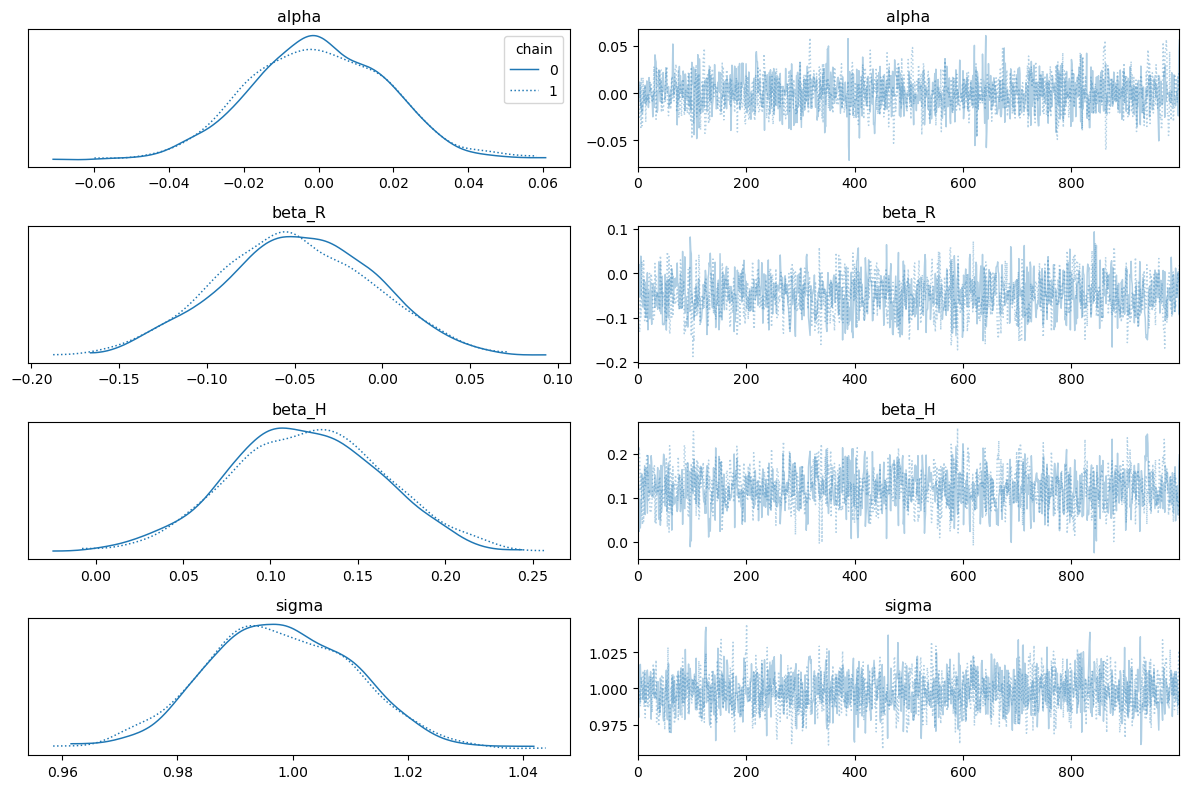

In [28]:
az.plot_trace(idata_lin, var_names = ["alpha", "beta_R", "beta_H", "sigma"], legend=True)
plt.tight_layout()
plt.show()

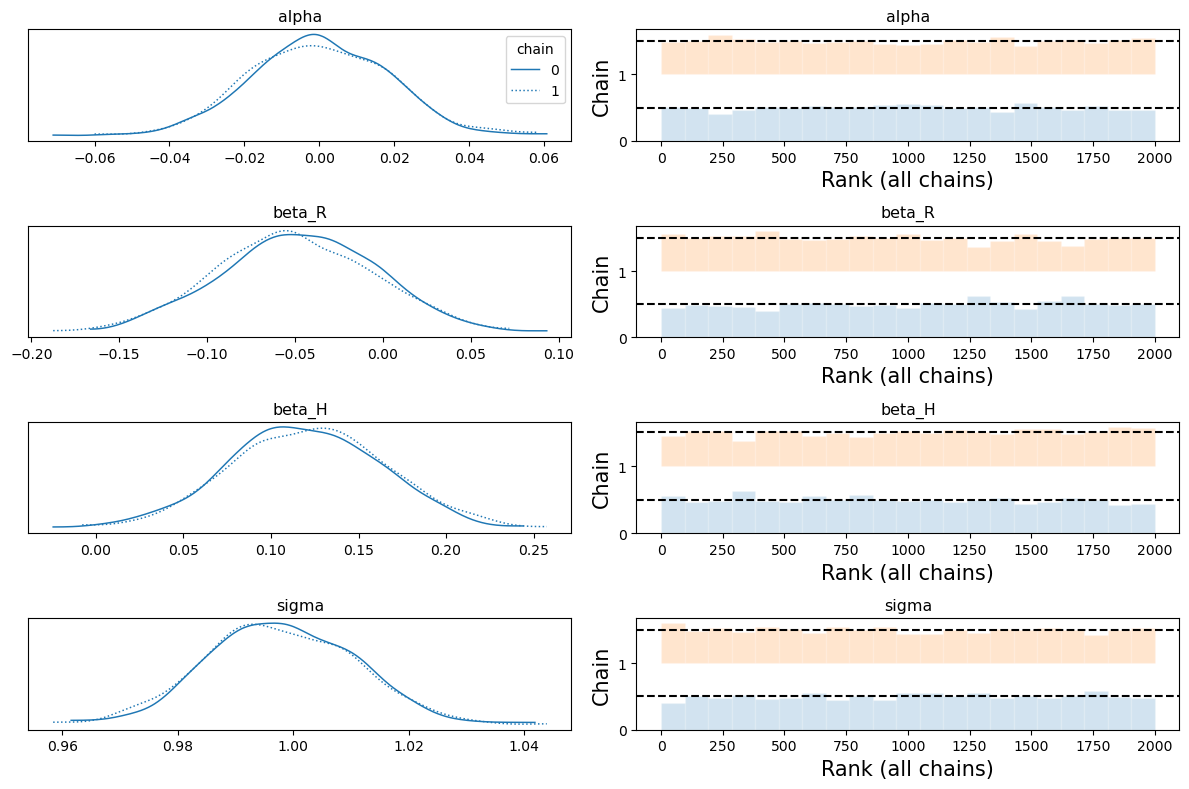

In [29]:
az.plot_trace(idata_lin, kind="rank_bars", var_names = ["alpha", "beta_R", "beta_H", "sigma"], legend=True)
plt.tight_layout()
plt.show()

According to the stats summary table of the linear version of the model, it shows the mean of $\beta_R$ is -0.049 and the mean of $\beta_H$ is 0.120. As the mean of $\beta_R$ is slightly negative, it implies that the reach has the inversely proportional influence to the number of significant strike landed per minute; longer the reach, lesser number of significant strike landed per minute. For the mean of $\beta_H$, which the value is slightly positive, it implies that the height has the proportional influence to the number of significant strike landed per minute; taller the height, greater number of significant strike landed per minute. 

This result of inversely proportional relation between the reach and the number of significant strike landed per minute is different from our initial assumption; we expected greater number of significant strike landed per minute when the reach gets longer. However, in our analysis, we did not account for the number of strikes that the opponent blocked or the style of the fighter, which could reflect the skills of the fighter as a striker. Thus, since we only considered the reach and the height when there could be other possible influential variables that could affect the number of significant strike landed per minute as well as the reach and the height, such as the fighting style, we cannot conclude that the reach will definitely have a inversely proportional influence and the height will definitely have a proportional influence to the number of significant strike per minute. 

However, in our initial assumption, we excluded the other possible influential factors, such as the fighting style, and formulated the hypothesis that longer reach will always be advantageous and lead to the greater number of significant strike landed per minute. Thus, the model which we only included the reach and height as a treatment and predictor variables could include the influences from other possible aspects we did not account, resulting in the reach having the inversely proportional influence and the height having the proportional influence to the number of significant strike landed per minute. 

Therefore, with our current model, it demonstrates that our assumption of the relation between the reach and the number of significant strike landed per minute is wrong since the reach has the inversely proportional effect on the number of significant strike landed per minute when the height is taken considered. Furthermore, more precise and accurate total and direct causal effects of the reach on the number of significant strike landed per minute would be studied in the future analysis if other possible confounds or influential variables are taken considered and applied to the model.

According to the diagnostics summary table of the linear version of the model, it shows ess_bulk greater than 400 and r_hat equals to 1.0 for every alpha, betas, and sigma. This illustrates that the sampling quality of the linear version of the model is great on the observed data.

Moreover, the trace plot shows that for every alpha, betas, and sigma, the two chains stay within the high probability region of the distribution (tendency to stay stable around the central) and the chains explore the full region of the posterior from the beginning of the trace. Also, the chains of the alpha, betas, and sigma show the convergence as each chain stays in the same high probability region and explores the same distributions with the appropriate posterior mean as shown in the stats summary table (chains for alpha has distribution with mean around 0, chains for $\beta_R$ has distribution with mean around -0.049, chains for $\beta_H$ has distribution with mean around 0.12, and chains for $\sigma$ has distribution wit mean around 0.998). Additionally, the bar graphs from the trace rank plot shows the relatively uniform distribution among the bars. Thus, by analyzing the diagnostics summary table with the trace and trace rank plots, it illustrates that the sampling quality of the linear version of the model on the observed data is great.

### Evaluate the Statistical Model with Simulated Data

With the linear version of the model, which we found to have a best performance of prediction, we will move on to generate the simulated data and evaluate if the model shows a reasonable performance.

In [30]:
alpha = 0.08
betaR = 0.3
betaH = 0.3
sigma = 1

N_SigStr = 200
reach = stats.uniform.rvs(-2.97, 5.72, N_SigStr)
height = stats.uniform.rvs(-2.60, 5.32, N_SigStr)
mu = alpha + betaR * reach + betaH * height
SigStr = stats.norm.rvs(mu, sigma, N_SigStr)

In [31]:
with pm.Model() as linM_sim:
    alpha = pm.Normal('alpha', mu = 0.08, sigma = 1.0)
    beta_R = pm.Normal('beta_R', mu = 0, sigma = 0.3)
    beta_H = pm.Normal('beta_H', mu = 0, sigma = 0.3)
    sigma = pm.Exponential('sigma', 1)
    
    mu = pm.Deterministic('mu', alpha + beta_R * reach + beta_H * height)
    SS = pm.Normal('SigStr', mu, sigma, observed = SigStr)

    idata_lin_sim = pm.sample(return_inferencedata=True, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_R, beta_H, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [32]:
az.summary(idata_lin_sim, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], kind = 'stats')

,mean,sd,hdi_3%,hdi_97%
alpha,0.191,0.076,0.050,0.332
beta_R,0.259,0.044,0.177,0.341
beta_H,0.316,0.047,0.228,0.400
sigma,1.042,0.052,0.954,1.143


In [33]:
az.summary(idata_lin_sim, var_names = ['alpha', 'beta_R', 'beta_H', 'sigma'], round_to = 2, kind = 'diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0,0.0,3634.03,1706.84,1.0
beta_R,0.0,0.0,2684.08,1663.34,1.0
beta_H,0.0,0.0,3245.87,1752.42,1.0
sigma,0.0,0.0,3041.54,1580.11,1.0


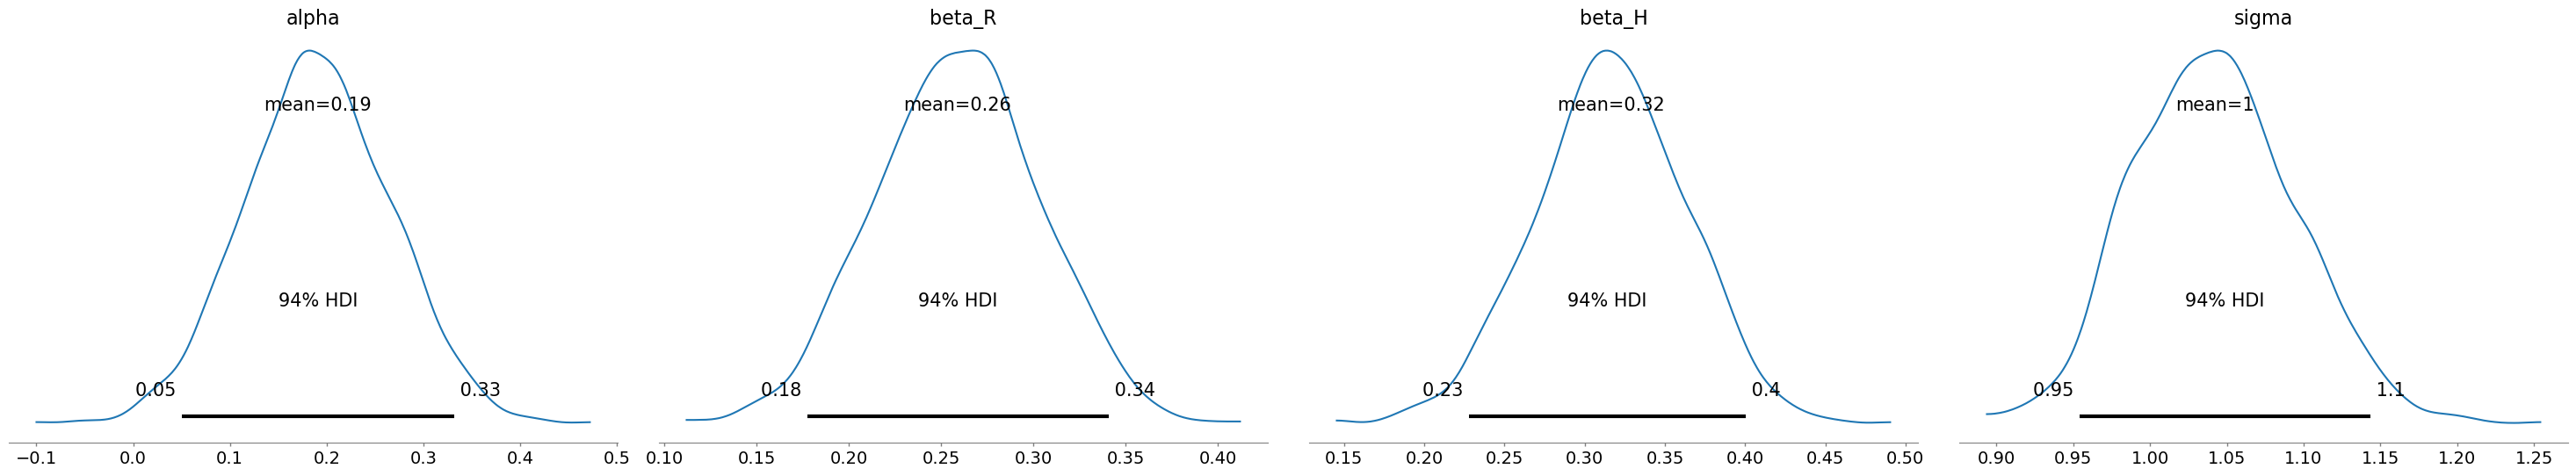

In [34]:
az.plot_posterior(idata_lin_sim, var_names = ["alpha", "beta_R", "beta_H", "sigma"])
plt.tight_layout()
plt.show()

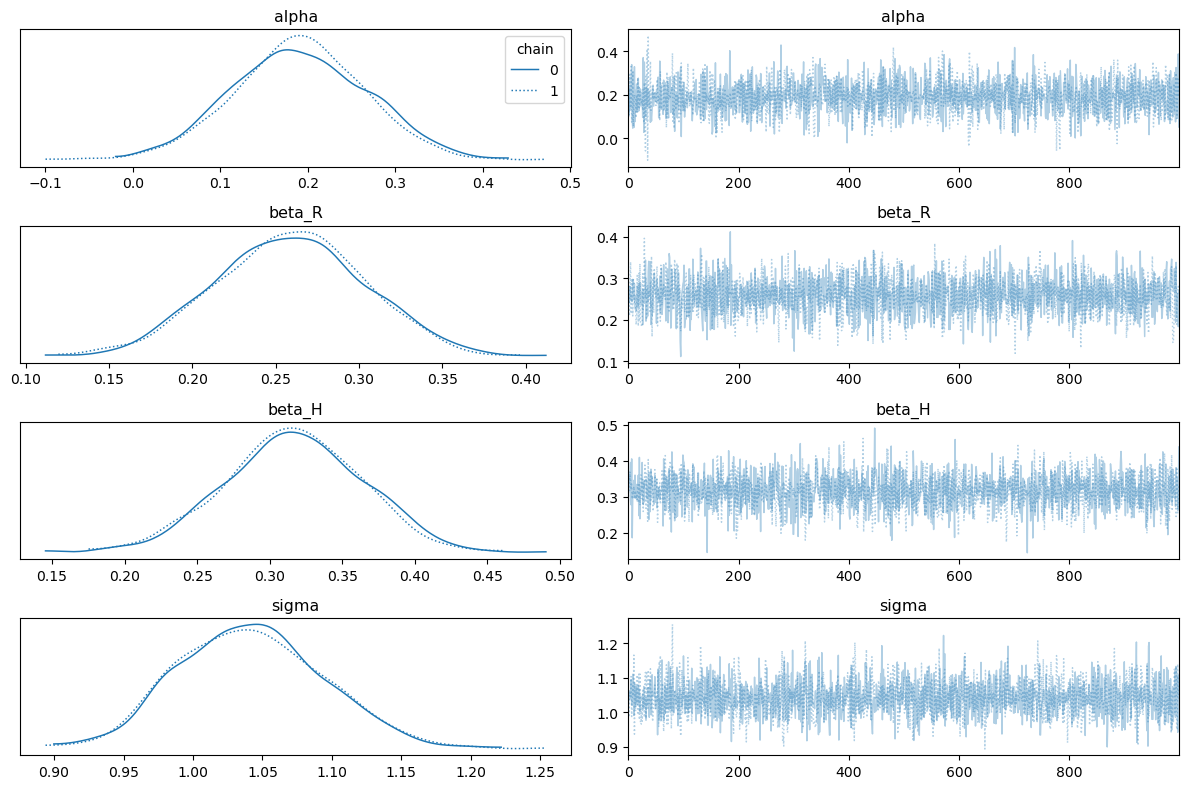

In [35]:
az.plot_trace(idata_lin_sim, var_names = ["alpha", "beta_R", "beta_H", "sigma"], legend=True)
plt.tight_layout()
plt.show()

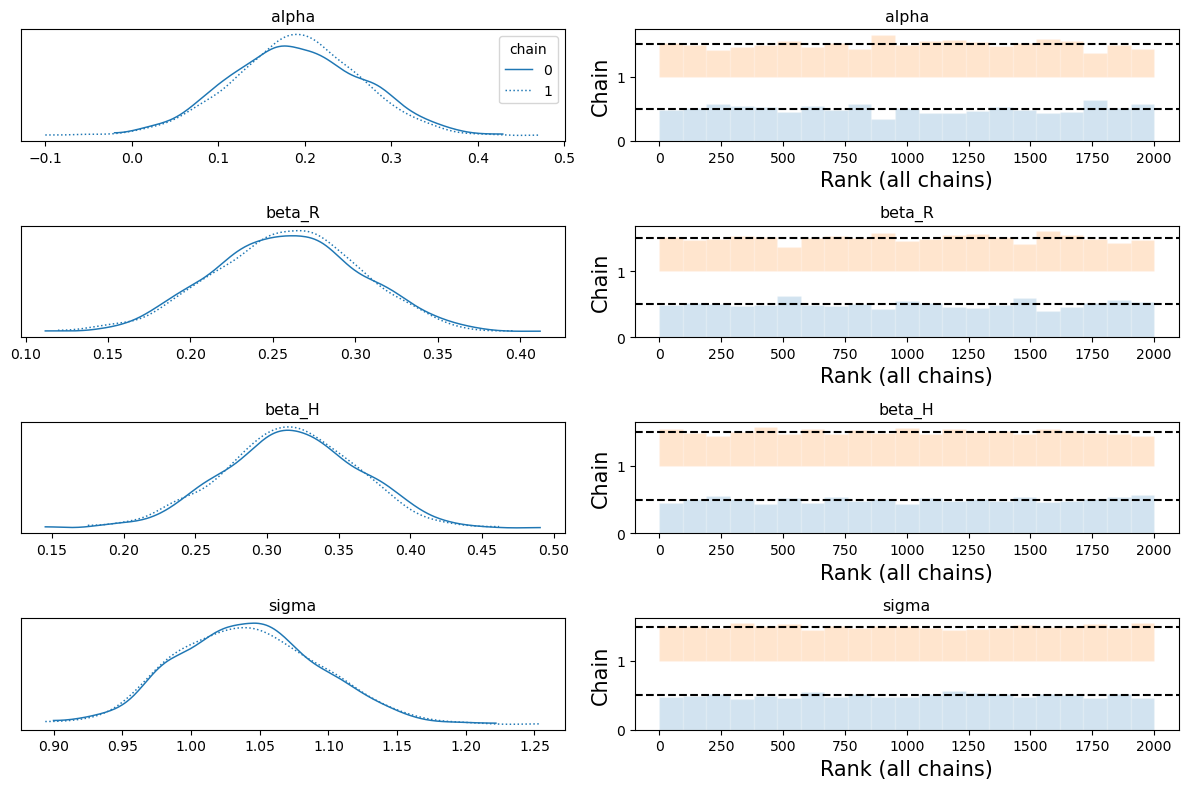

In [36]:
az.plot_trace(idata_lin_sim, kind = 'rank_bars', var_names = ["alpha", "beta_R", "beta_H", "sigma"], legend=True)
plt.tight_layout()
plt.show()

For the simulated data, we assumed $\alpha = 0.08$, $\beta_R = 0.3$, $\beta_H = 0.3$, and $\sigma = 1$. Also, we randomly sampled 200 standardized reach and height samples from the uniformly distributed probability within the appropriate range for each standardized reach and height, where we utilized each range we obtained from the observed data before. Using these 200 samples of the standardized reach and height as well as the pre-set alpha and betas, we computed the mu samples through the linear calculation used in the linear version of the model. Lastly, we obtained the simulated data of the standardized number of significant strike landed per minute by getting 200 simulated data from the normal distribution with the mu and sigma we computed and pre-set, respectively.

With the simulated data we obtained, we fitted the linear version of the model to the simulated data to evaluate. By comparing the pre-set alpha, betas, and sigma values with both the posterior mean of the alpha, betas, and sigma in the stats summary table and the posterior plot, it demonstrates that the posterior mean of the alpha, betas, and sigma of the posterior (shown in both the stats summary table and the posterior plot) are close to the pre-set values of alpha, betas, and sigma. Moreover, the trace plot of the posterior shows that the two chains stay within the high probability region of the distribution (tendency to stay stable around the central) and the chains explore the full region of the posterior from the beginning of the trace. Also, the chains of the alpha, betas, and sigma show the convergence as each chain stays in the same high probability region and explores the same distributions with the appropriate posterior mean as shown in the stats summary table, which are close to the pre-set values (chains for $\alpha$ has distribution with mean around 0.09, chains for $\beta_R$ has distribution with mean around 0.31, chains for $\beta_H$ has distribution with mean around 0.27, and chains for $\sigma$ has distribution wit mean around 1.07). Additionally, the bar graphs from the trace rank plot shows the relatively uniform distribution among the bars. Thus, by analyzing the diagnostics summary table with the trace and trace rank plots, it illustrates that the sampling quality of the linear version of the model on the simulated data is great.

## Posterior Predictive Checks

With the finding that the linear version of the model generates the posterior that converges well with the observed and simulated data, we will move onto the posterior predictive checks of the model. For the posterior predictive check, We will be plotting: 

- Observed data from the processed dataset: Red circles representing the observed data of number of significant strike landed per minute for each reach.

- Posterior predictive mean (average expectation): White line representing the average expectation of the number of significant strike landed per minute for each reach.
  
- Uncertainty of the posterior predictive mean (average expectation): Yellow region representing the uncertainty of the average expectation of the number of significant strike landed per minute for each reach.

- Uncertainty of the prediction: Gray region representing the uncertainty of the prediction of the number of significant strike landed per minute for each reach.

For the posterior prediction, we will use the reach_seq values, which we are dividing the range of the standardized reach by 2000 points, to multiply with the sampled $\beta_R$ in the calculation of the posterior prediction as well as the height_seq values, which we are dividing the range of the standardized height by 2000 points, multiplied to $\beta_H$.

In [37]:
with linM:
    post_pred_check = pm.sample_posterior_predictive(idata_lin, return_inferencedata = True, random_seed = 42)

Sampling: [SigStr]


In [38]:
reach_std_range = np.linspace(reach_std.min(), reach_std.max(), 2000)
height_std_range = np.linspace(height_std.min(), height_std.max(), 2000)

idata_lin_thinned = az.extract(idata_lin)

pred_mu = np.zeros((len(reach_std_range), idata_lin_thinned.sizes["sample"]))
pred_SigStr = np.zeros((len(reach_std_range), idata_lin_thinned.sizes["sample"]))
a_thinned_sample = idata_lin_thinned.alpha.values
bR_thinned_sample = idata_lin_thinned.beta_R.values
bH_thinned_sample = idata_lin_thinned.beta_H.values
sigma_thinned_sample = idata_lin_thinned.sigma.values

for i in range(2000):
    pred_mu[i] = a_thinned_sample + bR_thinned_sample * reach_std_range[i] + bH_thinned_sample * height_std_range[i]
    pred_SigStr[i] = np.random.normal(pred_mu[i], sigma_thinned_sample)

mu_mean = pred_mu.mean(1)

/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


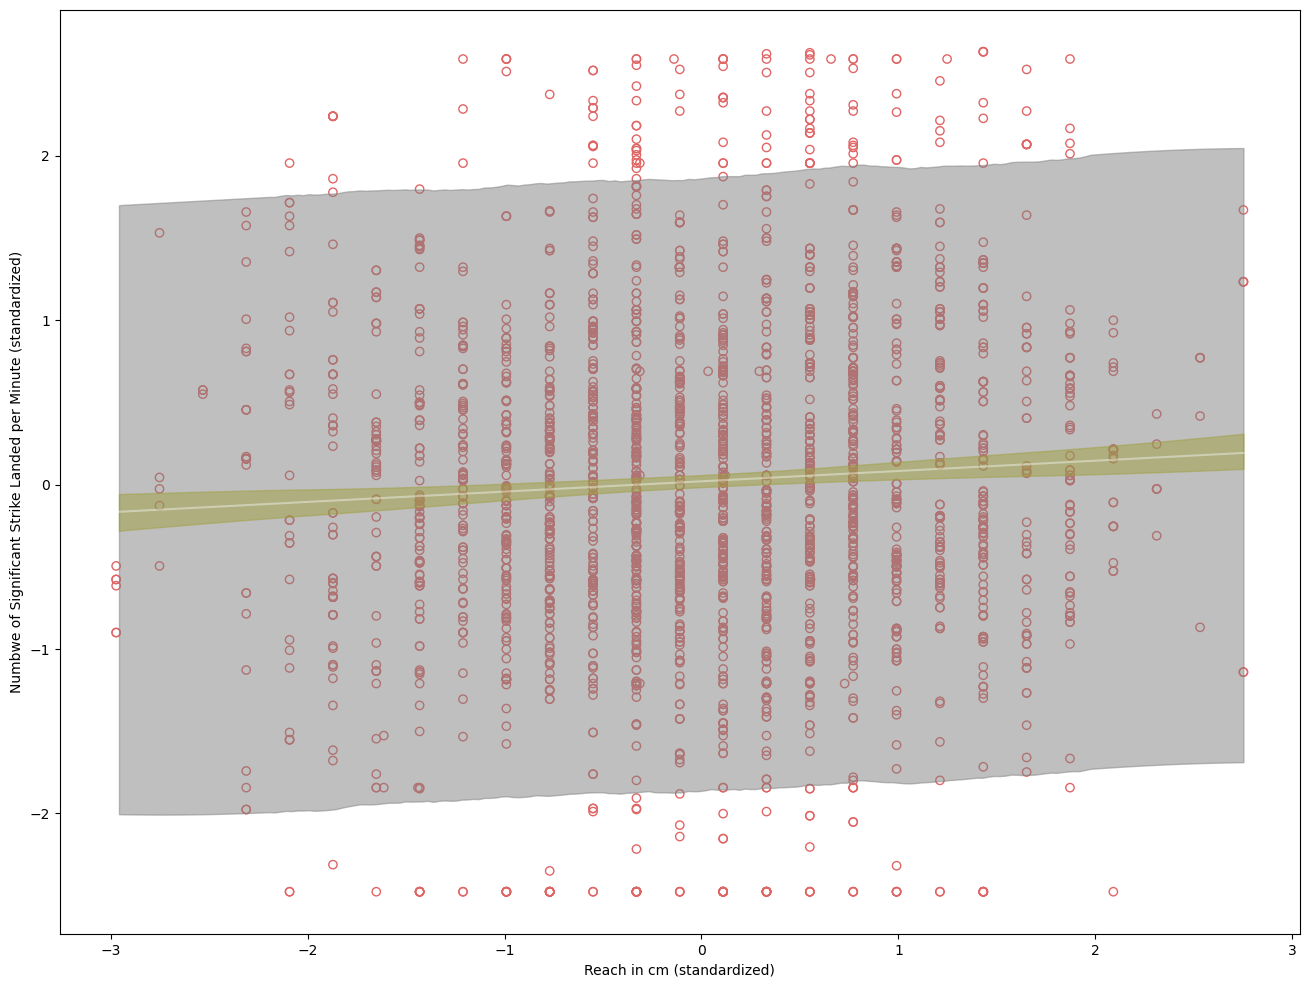

In [39]:
plt.figure(figsize = (16, 12))
plt.xlabel("Reach in cm (standardized)")
plt.ylabel("Numbwe of Significant Strike Landed per Minute (standardized)")
plt.scatter(x = reach_std, y = SigStr_std, facecolors='none', edgecolors="#e06666", label = "observed data")
plt.plot(reach_std_range, mu_mean, color = 'white', label = "posterior mean", alpha = 0.4)
ax = az.plot_hdi(reach_std_range, pred_mu.T, color = "y")
ax = az.plot_hdi(reach_std_range, pred_SigStr.T, color = "gray")

The above plot is the plot of the observed data with the plots of the posterior mean, uncertainty of the posterior mean, and the uncertainty of the prediction. We plotted the posterior predictive check plots using the 'sample_posterior_predictive()' to sample the posterior for alpha, betas, and sigma from the linear version of the model, computed the predictive mu, sampled the standardized number of significant strike landed per minute from the normal distribution with the computed mu and sampled sigma. For the uncertainty plots, we utilized the plot_hdi() and for the mean plot, we computed the mean of the computed mu. We are also going to plot the posterior predictive and the observed data together to analyze how well the linear model predicted the standardized number of significant strike landed per minute.

In [40]:
idata_lin_ex = idata_lin
idata_lin_ex.add_groups({"posterior_predictive": post_pred_check.posterior_predictive})


[]

/opt/conda/envs/fnds/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/envs/fnds/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


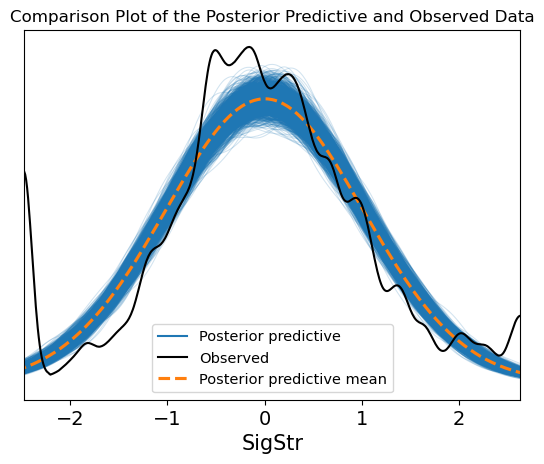

In [41]:
az.plot_ppc(idata_lin, data_pairs={"BlueAvgSigStrLanded": "BlueAvgSigStrLanded"})
# Limiting the X-axis to the range of the standardized number of significant strike landed per minute.
plt.xlim(-2.47,2.63)
plt.title("Comparison Plot of the Posterior Predictive and Observed Data")
plt.plot()

From the posterior predictive check plot above, which includes the observed data points (red circles), posterior mean (white line), uncertainty of the mean (yellow region), and the uncertainty of the prediction (gray region), we observed that while the uncertainty of the prediction covers a wide range, most of the observed data points falls inside the posterior predictive plots. Thus, since we also analyzed the performance of the linear version of the model with its convergence in the previous section, we can conclude that the linear version of the model also effectively perform on the prediction of the standardized number of significant strike landed per minute.

This conclusion is also supported by the second plot above, which compares the posterior predictive, posterior predictive mean and the observed data in the plot that is generated by az.plot_ppc(), as the posterior predictive plots (the blue lines) and the posterior predictive mean plot (the orange dotted line) mostly overlap with the observed data plot (the black line). This plot also illustrates that the posterior predictive and its mean are effectively fitting with the observed data on the standardized number of significant strike landed per minute through the linear version of the model.

## Conclusion

In this project, we analyzed the total and direct causal effect of the reach on the number of significant strike landed per minute with accounting the height as a confound among the UFC fighters. As the hypothesis of the analysis, we assumed that the reach will have a proportional influence on the number of significant strike landed per minute when the height is considered as a confounder since longer reach will allow the fighters to easily reach out to the opponent within their safety zone, thus can easily land more number of significant strike per minute. 

We began the project by formulating the causal model between the variables we considered in our project. Also, we imported the ufc_master.csv dataset and processed the dataset according to the information we researched on the average reach length, average height, and the greatest number of significant strike landed per minute to assume the average number of significant strike landed per minute. With the causal model and the processed dataset, we formulated the statistical model based on the causal model and proceeded to the prior predictive simulation in which we determined the reasonable distribution to be used for $\beta_R$ and $\beta_H$. 

After the priors are determined for the complete statistical model, different versions of the model are fitted to the standardized observed data (linear, quadratic, and cubic versions of the model), where the deterministic equation for computing the mu value are varied. PSIS and WAIC comparisons are done to compare the performance of the different versions of the model and we concluded that the linear version of the model performed the best for its highest rank and the lowest elpd_loo and elpd_waic scores.

As the linear version of the model is illustrated to be the best performing model, we sampled the posterior from the model on the observed data and analyzed the trace plot as well as the trace rank plot and the diagnostics summary table. Through the analysis, we observed that the sampling quality of the linear version of the model is great. Thus, we moved on to evaluate the model with the simulated data, which we generated by setting the reasonable alpha, betas, and sigma values as we used in the statistical model, and to fit the linear version of the model to the simulated data to generate the posterior of the simulated data. By analyzing the means of the posterior of the linear version of the model on the simulated data, we observed that the posterior mean values of the alpha, betas, and sigma are close to the ones we set for generating the simulated data. Also, by analyzing the trace/trace rank plots with the diagnostics summary table, we observed that the sampling quality is also great as evaluated before.

After evaluating the linear version of the model on the simulated data and its posterior sampling quality, the posterior predictive checks are done by plotting the observed data, posterior predictive mean, uncertainty of the posterior predictive mean, and uncertainty of the prediction on the same plot. By analyzing that most of the observed data points live within the posterior predictive plot, we concluded that the performance of the linear version of the model on predicting the standardized number of significant strike laneded per minute is effective. We also plotted the comparison of the observed data, posterior predictive mean, and the posterior predictive using the az.plot_ppc(), which illustrated that the posterior predictive mean and posterior predictive plots almost overlap with the observed data plot; thus it also supports the conclusion that the performance of the linear version of the model is effective.

Lastly, when we concluded that the linear version of the model performs the best among other versions of the model through PSIS and WAIC comparison, we analyzed the posterior summary table of the linear version of the model on the observed data. From the analysis, we learned that, unlike our hypothesis which we assumed the reach will have a proportional influence on the number of significant strike landed per minute, the reach actually had an inversely proportional influence on the number of significant strike landed per minute while the height had a proportional influence. Even though our assumption of the relation between the reach and the number of significant strike landed is wrong, this result could imply that as there are many other possible influential variables, such as the fighting style and defense skills of the opponents, that could also be the confounders with the height, more precise measurement of the total and direct causal effect of the reach on the number of significant strike landed per minute would be possible if more possible influential variables are taken into account as we did for height; it is hard to conclude with the result of the current statistical model on if the reach has the inversely proportional influence on the number of significant strike landed per minute or if the other variables are possibly influencing the reach and the number of significant strike landed per minute so that the result we obtained involves the influence from such variables. Thus, as the future project, we can explore with the statistical model with more possible confound variables, like the examples mentioned before, to analyze if the reach really have an inversely proportional influence on the number of significant strike landed per minute or not. 